In [96]:
# pip install pandas requests beautifulsoup4 matplotlib seaborn wordcloud textblob

In [97]:
# pip install --upgrade pip

In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import os
from sklearn.feature_extraction.text import CountVectorizer

In [113]:
base_url = "http://books.toscrape.com/catalogue/page-{}.html"
titles, ratings = [], []

for page in range(1, 10):  
    url = base_url.format(page)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, "html.parser")
    
    for book in soup.find_all("article", class_="product_pod"):
        title = book.h3.a["title"]
        rating_class = book.find("p", class_="star-rating")["class"][1]  
        
        titles.append(title)
        ratings.append(rating_class)

df = pd.DataFrame({"Review_Text": titles, "Rating": ratings})
rating_map = {"One":1, "Two":2, "Three":3, "Four":4, "Five":5}
df["Rating"] = df["Rating"].map(rating_map)
# print(df.head())
df.to_csv("reviews.csv", index=False)

In [114]:
# Load the scraped dataset
df = pd.read_csv("reviews.csv")

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Apply VADER on each review
df["neg"] = df["Review_Text"].apply(lambda x: sid.polarity_scores(str(x))["neg"])
df["neu"] = df["Review_Text"].apply(lambda x: sid.polarity_scores(str(x))["neu"])
df["pos"] = df["Review_Text"].apply(lambda x: sid.polarity_scores(str(x))["pos"])
df["compound"] = df["Review_Text"].apply(lambda x: sid.polarity_scores(str(x))["compound"])

# Label sentiment based on compound score
def get_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["compound"].apply(get_sentiment)

# print(df.head())

In [115]:
df.to_csv("vader.csv", index=False)
# print("✅ Saved vader.csv with Ratings + VADER scores")

In [116]:
df2=pd.read_csv('vader.csv')
# df2.head()

In [117]:
# print(df2.info())

In [118]:
# print(df2.describe(include="all"))

In [119]:
# print(df2["Sentiment"].value_counts())

In [120]:
fig = px.histogram(df2, x="Rating", nbins=5, title="Distribution of Ratings")
fig.show()

In [121]:
fig = px.histogram(df2, x="Sentiment", color="Sentiment",
                   category_orders={"Sentiment":["Positive","Neutral","Negative"]},
                   title="Sentiment Distribution (VADER)")
fig.show()

In [122]:
fig = px.box(df2, x="Rating", y="compound", points="all",
             title="Compound Sentiment Score vs Rating")
fig.show()

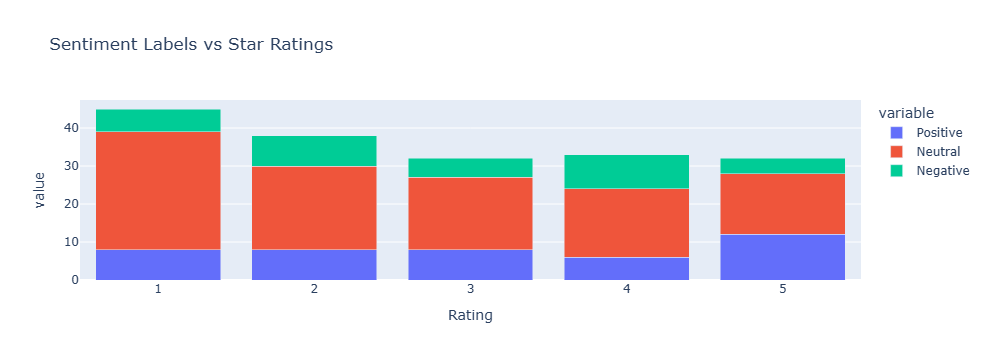

In [123]:
sentiment_rating = pd.crosstab(df2["Rating"], df2["Sentiment"]).reset_index()

fig = px.bar(sentiment_rating, x="Rating",
             y=["Positive","Neutral","Negative"],
             title="Sentiment Labels vs Star Ratings",
             barmode="stack")
fig.show()

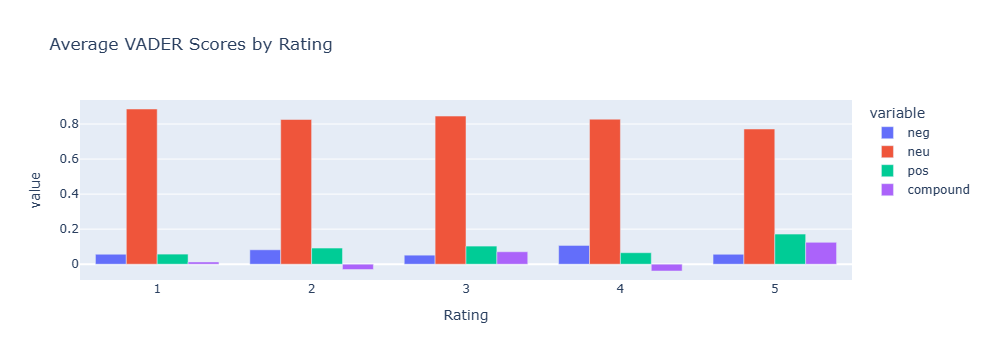

In [124]:
avg_scores = df2.groupby("Rating")[["neg","neu","pos","compound"]].mean().reset_index()

fig = px.bar(avg_scores, x="Rating", y=["neg","neu","pos","compound"],
             title="Average VADER Scores by Rating",
             barmode="group")
fig.show()

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

pos_words = [w.lower() for text in df2[df2["Sentiment"]=="Positive"]["Review_Text"]
             for w in text.split() if w.lower() not in stop]
neg_words = [w.lower() for text in df2[df2["Sentiment"]=="Negative"]["Review_Text"]
             for w in text.split() if w.lower() not in stop]

print("Top Positive Words:", Counter(pos_words).most_common(10))
print("Top Negative Words:", Counter(neg_words).most_common(10))